In [30]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Ziarno losowania 
SEED = 42
N_SPLITS = 5
N_REPEATS = 3

#### Wczytanie danych

<Axes: xlabel='TRIAGE', ylabel='count'>

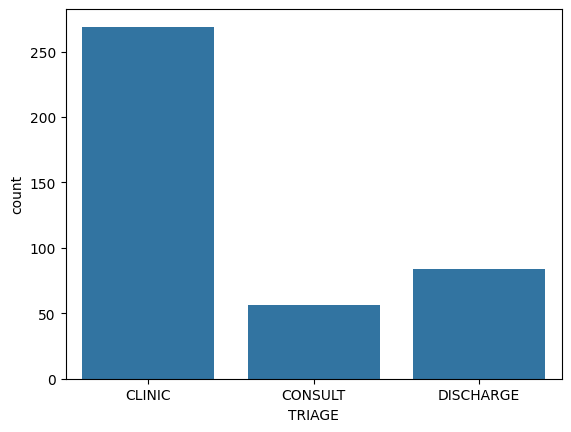

In [31]:
dataframe = pd.read_csv('resources/datasets/sp_retro/discretized.csv', na_values=('?',))
dataframe.head()
sns.countplot(x=dataframe.TRIAGE, data=dataframe)

#### Binaryzacja klasy decyzyjnej

In [32]:
X = dataframe.drop(columns=['TRIAGE'])
X = pd.get_dummies(X)
X = X.to_numpy()
y = (dataframe.TRIAGE == "CONSULT").astype(int).to_numpy()

#### Ocena klasyfikatora za pomocą 5-krotnej warstwowej walidacji krzyżowej (stratified crossvalidation) powtórzonej 3-krotnie 

In [53]:
# Compute area under the precision-recall curve, not receiver operating characteristic curve.
def calc_auprc(y, y_pred): 
    precision, recall, _ = metrics.precision_recall_curve(y, y_pred)
    # metrics.auc(x,y) - compute Area Under the Curve (AUC). This is a general function, given points on a curve.
    return metrics.auc(recall, precision)

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
def calc_auroc(y, pred):
    return metrics.roc_auc_score(y, pred)

def calc_sensitivity(y_true, y_predicted):
    true_positives = sum((y_true == 1) & (y_predicted == 1))
    false_negatives = sum((y_true == 1) & (y_predicted == 0))
    
    if true_positives + false_negatives == 0:
        return 0  # to handle division by zero
    return true_positives / (true_positives + false_negatives)

def calc_specificity(y_true, y_predicted):
    true_negatives = sum((y_true == 0) & (y_predicted == 0))
    false_positives = sum((y_true == 0) & (y_predicted == 1))
    
    if true_negatives + false_positives == 0:
        return 0  # to handle division by zero
    
    return true_negatives / (true_negatives + false_positives)

# returns tuple[medium-risk, high-risk]
def calculate_tresholds(y_true, y_predicted):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    sensitivity, specificity = tpr, 1 - fpr

    medium_risk = thresholds[np.where(sensitivity >= 0.99)[0][0]] if np.any(sensitivity >= 0.99) else None
    high_risk = thresholds[np.where(specificity >= 0.90)[0][-1]] if np.any(specificity >= 0.90) else None

    return medium_risk, high_risk

def classify_responses(y_pred, medium_risk, high_risk):
    return np.array([
            0 if response < medium_risk else 1 if response >= high_risk else np.nan
            for response in y_pred
        ])

def calculate_fnr_tnr(y, y_pred):
    tn, tp, fn, fp = metrics.confusion_matrix(y, y_pred).ravel()
    tpr = tp / (tp + fn)  # sensitivity
    fnr = fn / (fn + tp)  # miss_rate
    fpr = fp / (fp + tn)  # fall_out
    tnr = tn / (tn + fp)  # specificity

    return tpr, fnr, fpr, tnr

def plot(results, title: str):
  format = lambda val: f'{val * 100:.2f}%'
  colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
  figure, axis = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)


  axis[0, 0].bar(['FNR', 'TNR', 'TPR', 'FPR'], [results.fnr, results.tnr, results.tpr, results.fpr], color=colors)
  axis[0, 0].set_ylabel('Rate')
  axis[0, 0].set_xlabel('Rate Type')
  for i, value in enumerate([results.fnr, results.tnr, results.tpr, results.fpr]):
    axis[0, 0].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[0, 1].bar(['AUPRC', 'AUROC'], [results.auprc, results.auroc], color=colors )
  axis[0, 1].set_ylabel('Score')
  axis[0, 1].set_xlabel('Score Type')
  for i, value in enumerate([results.auprc, results.auroc]):
    axis[0, 1].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')

  axis[1,0].bar(
    ['Negatives', 'Positives', 'Unknowns'],
    [results['negative'], results['positive'], results['unknown']],
    color=colors
  )
  axis[1,0].set_ylabel('Rate')
  axis[1,0].set_xlabel('Rate Type')
  axis[1,0].text(0, results.negative, format(results.negative), ha='center', va='bottom')
  axis[1,0].text(1, results.positive, format(results.positive), ha='center', va='bottom')
  axis[1,0].text(2, results.unknown, format(results.unknown), ha='center', va='bottom')

  axis[1,1].axis("off")
  figure.suptitle(title)
  figure.show()


In [45]:
def run_classifier(classfier, seed, n_splits, n_repeats):
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    results = []
    
    for train_idx, test_idx in rskf.split(X, y):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        n_samples = len(y_te)
        classfier.fit(X_tr, y_tr)

        # Calculate tresholds 
        y_pred_tr = classfier.predict_proba(X_tr)[:,1]
        medium_risk, high_risk = calculate_tresholds(y_tr, y_pred_tr)

        # Predict labels on test set
        y_prob = classfier.predict_proba(X_te)[:,1]
        auprc = calc_auprc(y_te, y_prob) 
        auroc = calc_auroc(y_te, y_prob)
        y_pred = classify_responses(y_prob, medium_risk, high_risk)

        # Calculate metrics
        positive = np.sum(y_pred == 1)
        negative = np.sum(y_pred == 0)
        unknown = np.sum(np.isnan(y_pred))

        mask = ~np.isnan(y_pred) #remove nans
        y_pred_th = y_pred[mask]
        y_te_th = y_te[mask]

        tpr, fnr, fpr, tnr = calculate_fnr_tnr(y_te_th, y_pred_th)
        res = dict(auprc=auprc, auroc=auroc, fnr=fnr, tnr=tnr, tpr=tpr, fpr=fpr, positive=positive/n_samples, negative=negative/n_samples, unknown=unknown/n_samples)
        print(res)
        results.append(res)
    
    return results

{'auprc': 0.45738184559178363, 'auroc': 0.7861715749039694, 'fnr': 0.08333333333333333, 'tnr': 0.8, 'tpr': 0.9166666666666666, 'fpr': 0.2, 'positive': 0.2073170731707317, 'negative': 0.3048780487804878, 'unknown': 0.4878048780487805}
{'auprc': 0.5319176250092926, 'auroc': 0.8040973111395646, 'fnr': 0.0, 'tnr': 0.7692307692307693, 'tpr': 1.0, 'fpr': 0.23076923076923078, 'positive': 0.1951219512195122, 'negative': 0.24390243902439024, 'unknown': 0.5609756097560976}
{'auprc': 0.4074284096402978, 'auroc': 0.7477592829705506, 'fnr': 0.0, 'tnr': 0.782608695652174, 'tpr': 1.0, 'fpr': 0.21739130434782608, 'positive': 0.21951219512195122, 'negative': 0.21951219512195122, 'unknown': 0.5609756097560976}
{'auprc': 0.7283027021997611, 'auroc': 0.9178571428571428, 'fnr': 0.0, 'tnr': 0.6363636363636364, 'tpr': 1.0, 'fpr': 0.36363636363636365, 'positive': 0.13414634146341464, 'negative': 0.17073170731707318, 'unknown': 0.6951219512195121}
{'auprc': 0.5584826962544278, 'auroc': 0.742857142857143, 'fnr'

C:\Users\milos\AppData\Local\Temp\ipykernel_21912\3660936434.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


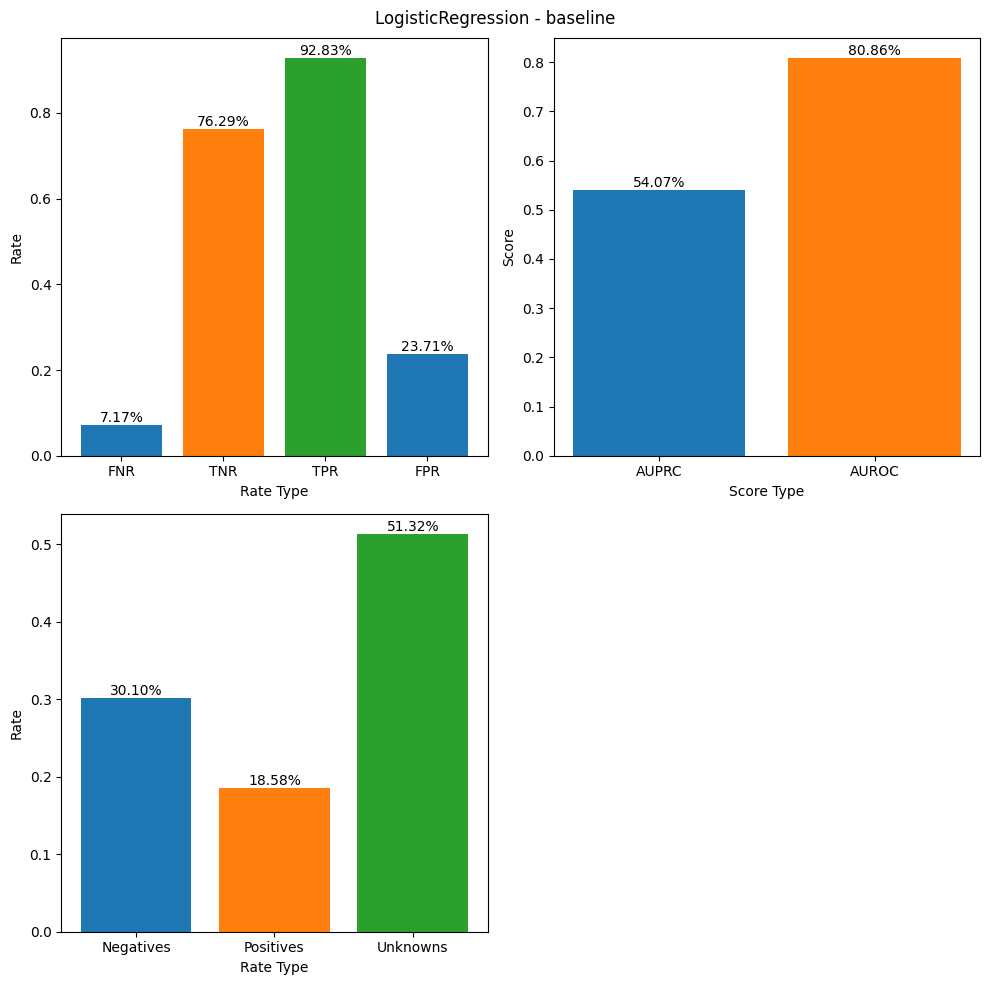

In [63]:
clf = LogisticRegression(random_state=SEED, max_iter=10000)
results = run_classifier(clf, seed=SEED, n_splits=N_SPLITS, n_repeats=N_REPEATS)

df = pd.DataFrame(results).mean()
print(df)
plot(df, "LogisticRegression - baseline")


In [55]:
def run_classifier2(seed, n_splits, n_repeats):
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    results = []

    classfier = RandomForestClassifier(
                    class_weight="balanced",
                    random_state=42,
                    min_samples_leaf=8,
                    min_samples_split=2,
                    n_estimators=75,
    )
    
    for train_idx, test_idx in rskf.split(X, y):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        sm = SMOTE(random_state=42)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
        n_samples = len(y_te)
        classfier.fit(X_tr, y_tr)

        # Calculate tresholds 
        y_pred_tr = classfier.predict_proba(X_tr)[:,1]
        medium_risk, high_risk = calculate_tresholds(y_tr, y_pred_tr)

        # Predict labels on test set
        y_prob = classfier.predict_proba(X_te)[:,1]
        auprc = calc_auprc(y_te, y_prob) 
        auroc = calc_auroc(y_te, y_prob)
        y_pred = classify_responses(y_prob, medium_risk, high_risk)

        # Calculate metrics
        positive = np.sum(y_pred == 1)
        negative = np.sum(y_pred == 0)
        unknown = np.sum(np.isnan(y_pred))

        mask = ~np.isnan(y_pred) #remove nans
        y_pred_th = y_pred[mask]
        y_te_th = y_te[mask]

        tpr, fnr, fpr, tnr = calculate_fnr_tnr(y_te_th, y_pred_th)
        res = dict(auprc=auprc, auroc=auroc, fnr=fnr, tpr=tpr, fpr=fpr, tnr=tnr, positive=positive/n_samples, negative=negative/n_samples, unknown=unknown/n_samples)
        print(res)
        results.append(res)
    
    return results

{'auprc': 0.4690888650218794, 'auroc': 0.8104993597951344, 'fnr': 0.11764705882352941, 'tpr': 0.8823529411764706, 'fpr': 0.1568627450980392, 'tnr': 0.8431372549019608, 'positive': 0.2804878048780488, 'negative': 0.5487804878048781, 'unknown': 0.17073170731707318}
{'auprc': 0.58791334050051, 'auroc': 0.8015364916773368, 'fnr': 0.1111111111111111, 'tpr': 0.8888888888888888, 'fpr': 0.12727272727272726, 'tnr': 0.8727272727272727, 'positive': 0.2804878048780488, 'negative': 0.6097560975609756, 'unknown': 0.10975609756097561}
{'auprc': 0.38724939957244264, 'auroc': 0.7144686299615877, 'fnr': 0.2857142857142857, 'tpr': 0.7142857142857143, 'fpr': 0.1016949152542373, 'tnr': 0.8983050847457628, 'positive': 0.1951219512195122, 'negative': 0.6951219512195121, 'unknown': 0.10975609756097561}
{'auprc': 0.8361125027457981, 'auroc': 0.9452380952380952, 'fnr': 0.2, 'tpr': 0.8, 'fpr': 0.16071428571428573, 'tnr': 0.8392857142857143, 'positive': 0.15853658536585366, 'negative': 0.5853658536585366, 'unknow

C:\Users\milos\AppData\Local\Temp\ipykernel_21912\3660936434.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


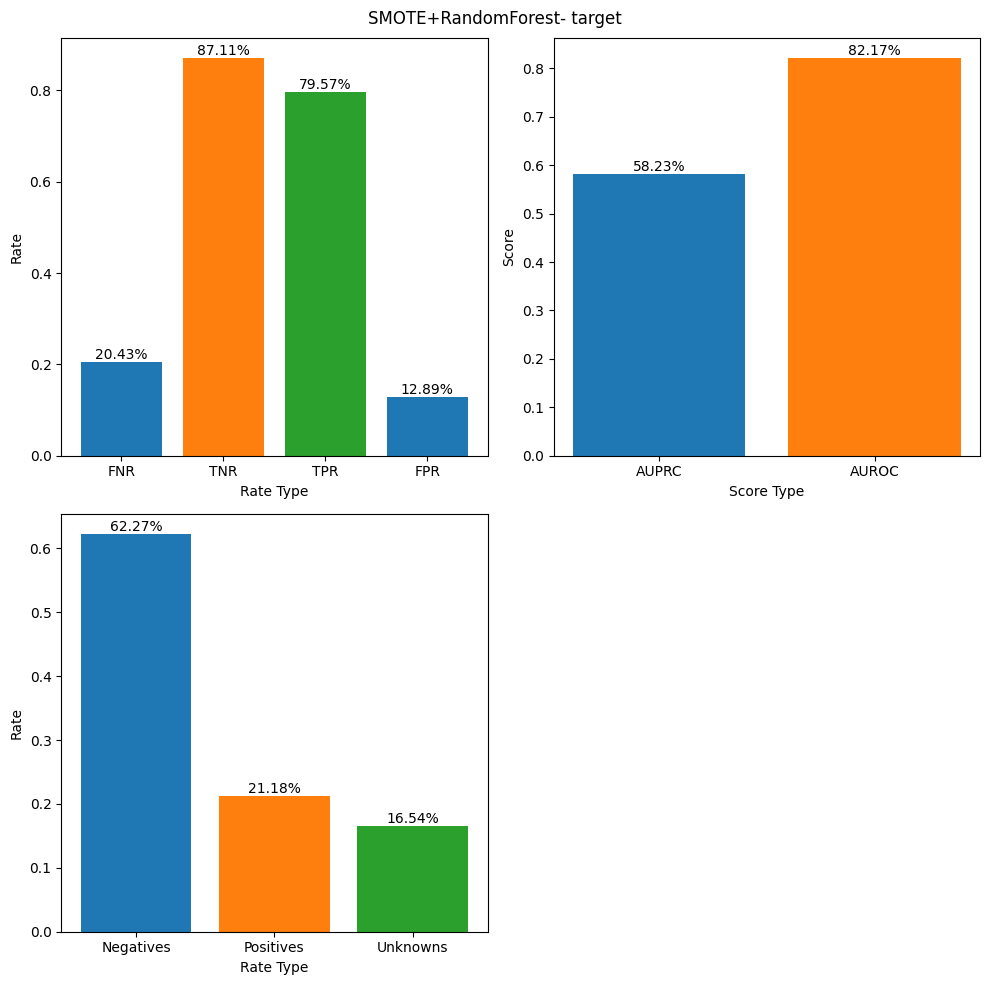

In [65]:
results = run_classifier2( seed=SEED, n_splits=N_SPLITS, n_repeats=N_REPEATS)

df = pd.DataFrame(results).mean()
print(df)

plot(df, "SMOTE+RandomForest- target")